In [1]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from matplotlib.ticker import FormatStrFormatter
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)

    return (frequencies, psd)


In [3]:
def get_efd_data(begin, end, client):

    """Extract all the MTMount data from the EFD and add to dict.

    Args:
        begin (str): The start time of the query.
        end (str): The end time of the query.
        client (object): influx client

    Returns:
        dict: A dictionary containing the MTMount data.
    """

    query_dict = {}

    query_dict["el"] = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=["*"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    query_dict["az"] = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=["*"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    query_dict["ims"] = getEfdData(
        client,
        "lsst.sal.MTM1M3.imsData",
        columns=["*"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    
    # query_dict["hp"] = getEfdData(
    #     client,
    #     "lsst.sal.MTM1M3.hardpointActuatorData",
    #     columns=["timestamp", "measuredForce0", "measuredForce1", "measuredForce2", "measuredForce3", "measuredForce4", "measuredForce5"],
    #     begin=begin,
    #     end=end,
    #     prePadding=0,
    #     postPadding=0,
    #     warn=False,
    # )
    
    return query_dict


In [4]:
begin_time=Time('2023-06-28 01:08:00', format="iso", scale="utc")
end_time=Time('2023-06-28 01:20:00', format="iso", scale="utc")
raised_begin=Time('2023-06-28 01:08:15', format="iso", scale="utc")
raised_end=Time('2023-06-28 01:11:55', format="iso", scale="utc")
lowering_end=Time('2023-06-28 01:15:15', format="iso", scale="utc")
down_end=Time('2023-06-28 01:20:00', format="iso", scale="utc")
time_dict={}
time_dict["total"]={"begin":begin_time, "end":end_time}
time_dict["raised"]={"begin":begin_time, "end":raised_end}
time_dict["lowering"]={"begin":raised_end, "end":lowering_end}
time_dict["down"]={"begin":lowering_end, "end":end_time}

In [5]:
client=makeEfdClient()
efd_dict=get_efd_data(begin_time, end_time, client)

Text(0.5, 1.0, 'IMS Position\n2023-06-28 01:08:00-01:20:00')

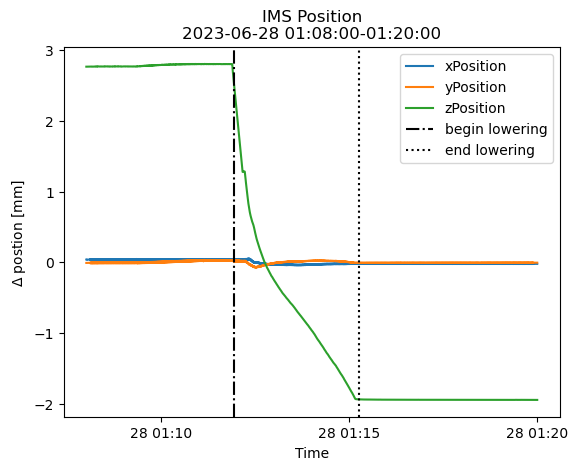

In [6]:
times=Time(efd_dict["ims"]["timestamp"], format="unix_tai", scale="utc").datetime
for key in ["xPosition","yPosition","zPosition"]:
    plt.plot(times, (efd_dict["ims"][key]- efd_dict["ims"][key].mean())* 1e3, label=key)

plt.axvline(time_dict["raised"]["end"].datetime, label="begin lowering", c="k", ls="dashdot")
plt.axvline(time_dict["lowering"]["end"].datetime, label="end lowering", c="k", ls="dotted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("$\Delta$ postion [mm]")
plt.title(f"IMS Position\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")

Text(0.5, 1.0, 'IMS Position\n2023-06-28 01:08:00-01:20:00')

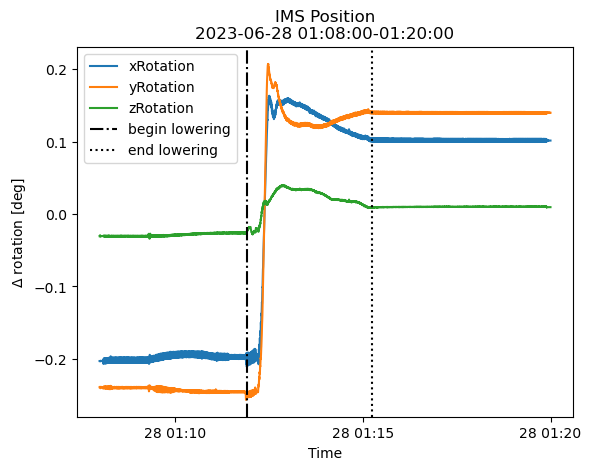

In [7]:
times=Time(efd_dict["ims"]["timestamp"], format="unix_tai", scale="utc").datetime
for key in ["xRotation","yRotation","zRotation"]:
    plt.plot(times, np.rad2deg(efd_dict["ims"][key]- efd_dict["ims"][key].mean()), label=key)

plt.axvline(time_dict["raised"]["end"].datetime, label="begin lowering", c="k", ls="dashdot")
plt.axvline(time_dict["lowering"]["end"].datetime, label="end lowering", c="k", ls="dotted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("$\Delta$ rotation [deg]")
plt.title(f"IMS Position\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")

(-20000000.0, 30000000.0)

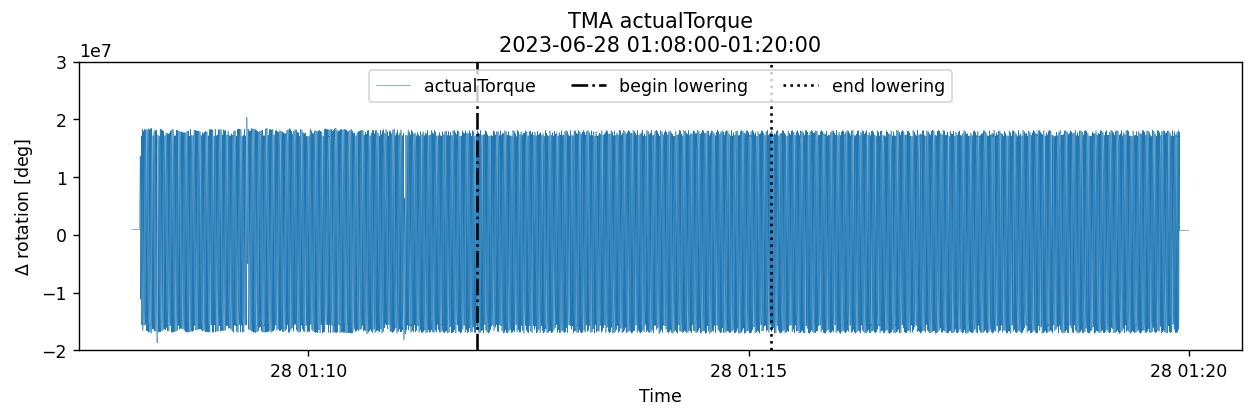

In [8]:
times=Time(efd_dict["el"]["timestamp"], format="unix_tai", scale="utc").datetime
plt.figure(dpi=125, figsize=(12,3))
for key in ["actualTorque"]:
    plt.plot(times, np.rad2deg(efd_dict["el"][key]- efd_dict["el"][key].mean()), label=key, lw=0.3)

plt.axvline(time_dict["raised"]["end"].datetime, label="begin lowering", c="k", ls="dashdot")
plt.axvline(time_dict["lowering"]["end"].datetime, label="end lowering", c="k", ls="dotted")
plt.legend(ncol=3, loc=9)
plt.xlabel("Time")
plt.ylabel("$\Delta$ rotation [deg]")
plt.title(f"TMA actualTorque\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
plt.ylim(-2e7,3e7)

Text(0.5, 1.0, 'TMA Elevation actualTorque\nEvent 2023-06-28 01:08:00-01:20:00')

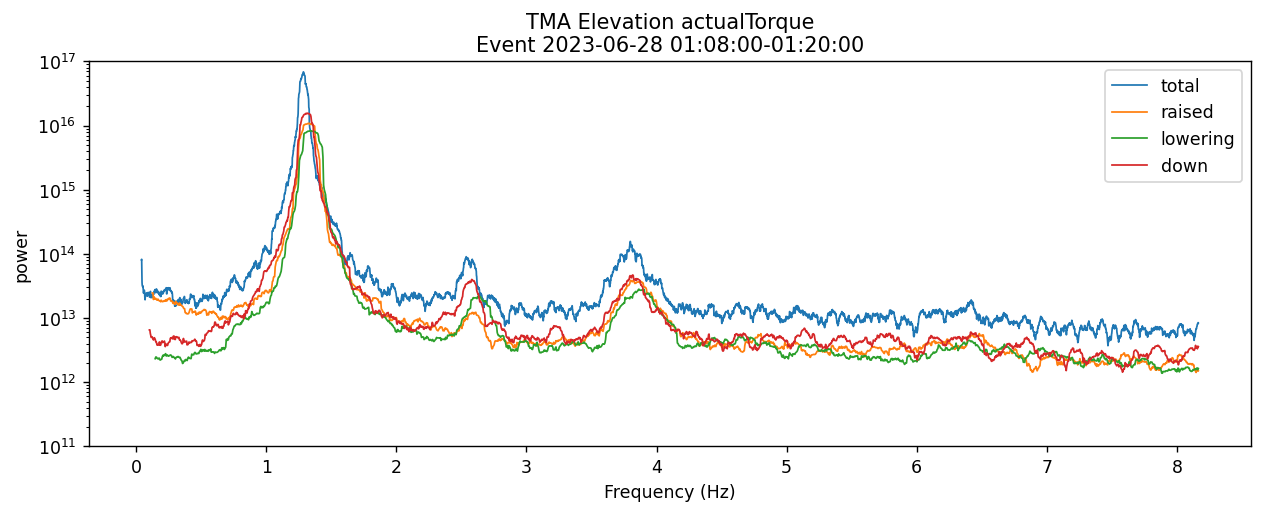

In [10]:
dict_key="el"
key="actualTorque"
times=Time(efd_dict[dict_key]["timestamp"], format="unix_tai", scale="utc")
fs=1/np.mean(np.diff(times.unix))
plt.figure(dpi=125, figsize=(12,4))
for time_key in time_dict.keys():
    sel=(times > time_dict[time_key]["begin"])
    sel&=(times <= time_dict[time_key]["end"])
    vals=efd_dict[dict_key][key][sel]


    freq,psd=get_freq_psd(vals, 1/fs)
    yvals=pd.DataFrame({"psd":psd})["psd"].rolling(30).mean()
    plt.plot(freq,yvals, zorder=9, lw=1, label=time_key)
plt.yscale('log')
plt.ylim(1e11,1e17)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("power")
plt.title(f"TMA Elevation {key}\nEvent {begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")

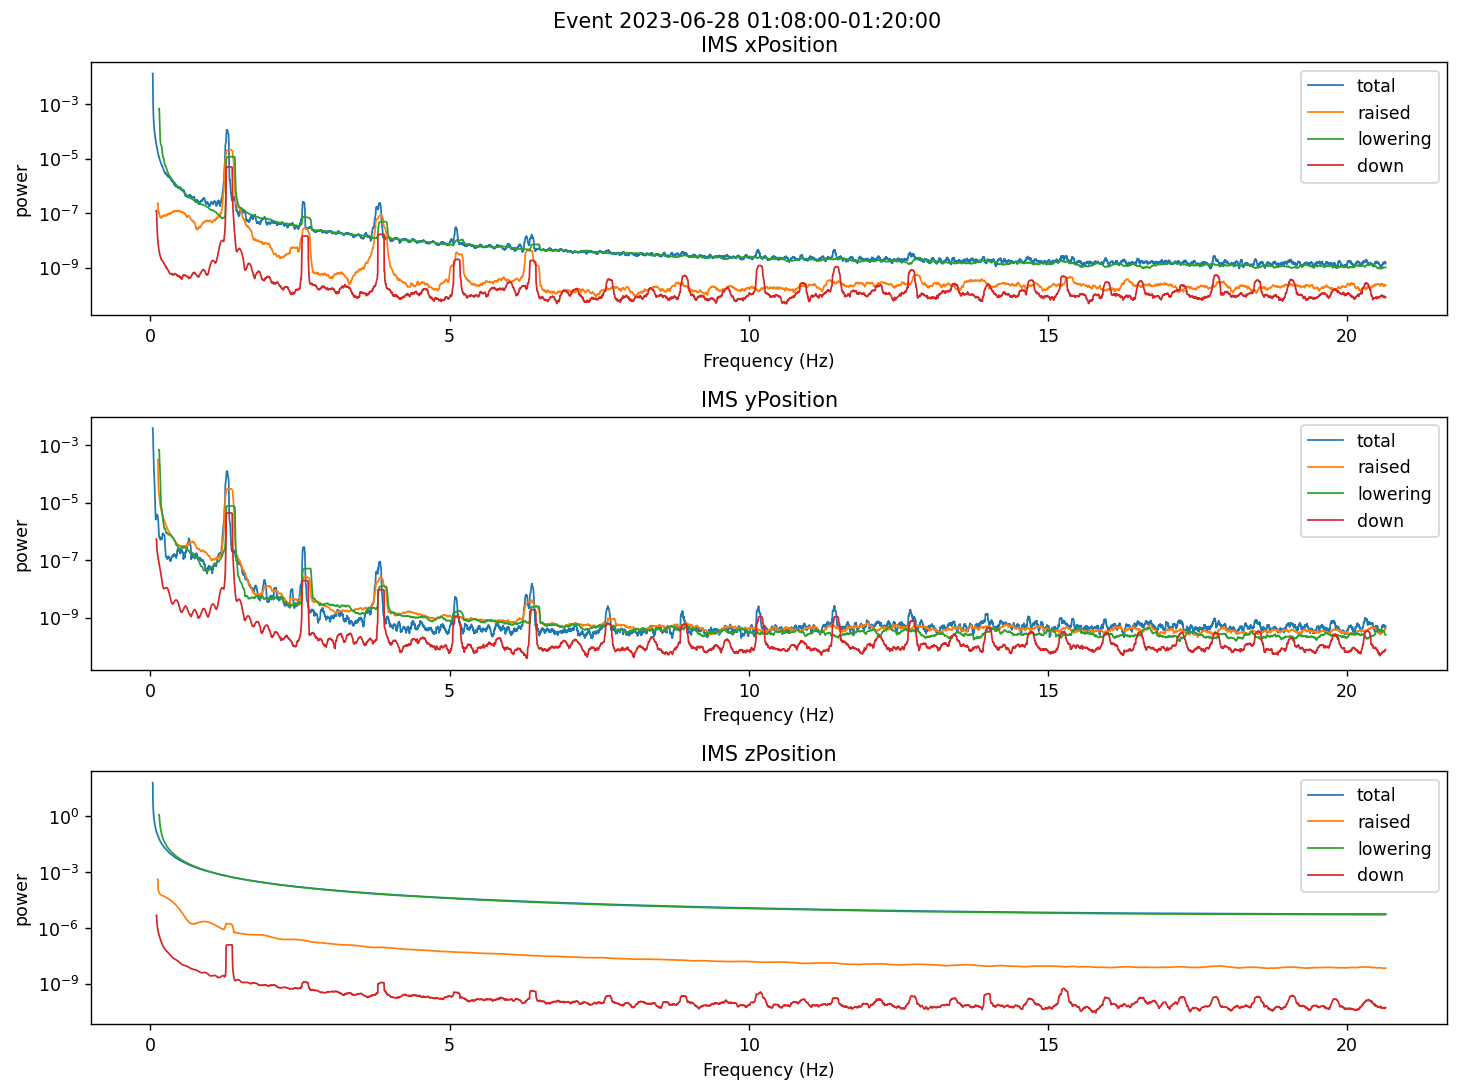

In [13]:
dict_key="ims"
fig, axs=plt.subplots(3,1,dpi=125, figsize=(14,10))
plt.suptitle(f"Event {begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.92)
for i,key in enumerate(["xPosition","yPosition","zPosition"]):
    ax=axs[i]
    times=Time(efd_dict[dict_key]["timestamp"], format="unix_tai", scale="utc")
    fs=1/np.mean(np.diff(times.unix))
    for time_key in time_dict.keys():
        sel=(times > time_dict[time_key]["begin"])
        sel&=(times <= time_dict[time_key]["end"])
        vals=efd_dict[dict_key][key][sel]


        freq,psd=get_freq_psd(vals, 1/fs)
        yvals=pd.DataFrame({"psd":psd})["psd"].rolling(30).mean()
        ax.plot(freq,yvals, zorder=9, lw=1, label=time_key)
    title_str=f"IMS {key}"
    ax.set(yscale='log', xlabel="Frequency (Hz)",ylabel="power", title=title_str)
    #plt.ylim(1e11,1e17)
    ax.legend()
plt.subplots_adjust(hspace=0.4)

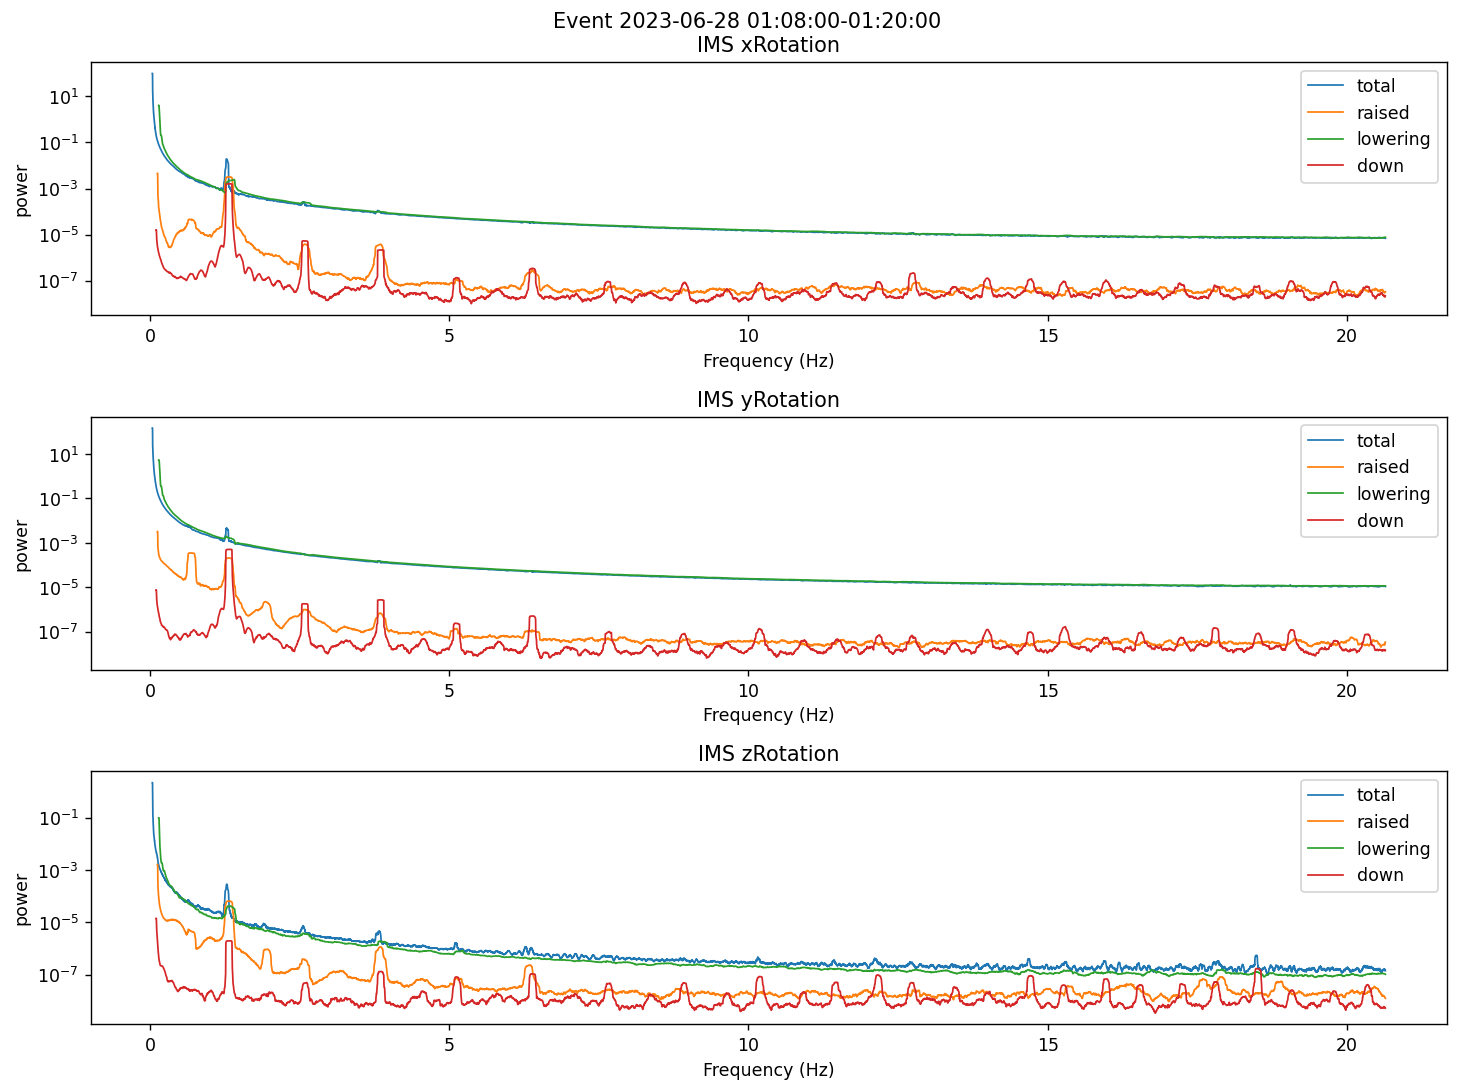

In [14]:
dict_key="ims"
fig, axs=plt.subplots(3,1,dpi=125, figsize=(14,10))
plt.suptitle(f"Event {begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.92)
for i,key in enumerate(["xRotation","yRotation","zRotation"]):
    ax=axs[i]
    times=Time(efd_dict[dict_key]["timestamp"], format="unix_tai", scale="utc")
    fs=1/np.mean(np.diff(times.unix))
    for time_key in time_dict.keys():
        sel=(times > time_dict[time_key]["begin"])
        sel&=(times <= time_dict[time_key]["end"])
        vals=efd_dict[dict_key][key][sel]


        freq,psd=get_freq_psd(vals, 1/fs)
        yvals=pd.DataFrame({"psd":psd})["psd"].rolling(30).mean()
        ax.plot(freq,yvals, zorder=9, lw=1, label=time_key)
    title_str=f"IMS {key}"
    ax.set(yscale='log', xlabel="Frequency (Hz)",ylabel="power", title=title_str)
    #plt.ylim(1e11,1e17)
    ax.legend()
plt.subplots_adjust(hspace=0.4)

In [ ]:
for i,key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x=get_peak_points(freq, psd)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

In [18]:
times

array([datetime.datetime(2023, 6, 28, 1, 7, 59, 970450),
       datetime.datetime(2023, 6, 28, 1, 8, 0, 20330),
       datetime.datetime(2023, 6, 28, 1, 8, 0, 70200), ...,
       datetime.datetime(2023, 6, 28, 1, 19, 59, 814340),
       datetime.datetime(2023, 6, 28, 1, 19, 59, 864230),
       datetime.datetime(2023, 6, 28, 1, 19, 59, 914180)], dtype=object)

In [24]:
fs=1/np.mean(np.diff(times.unix))
fs

16.329053936073056

[Text(0, 0.5, 'Channel 1\nFreq [hz]'),

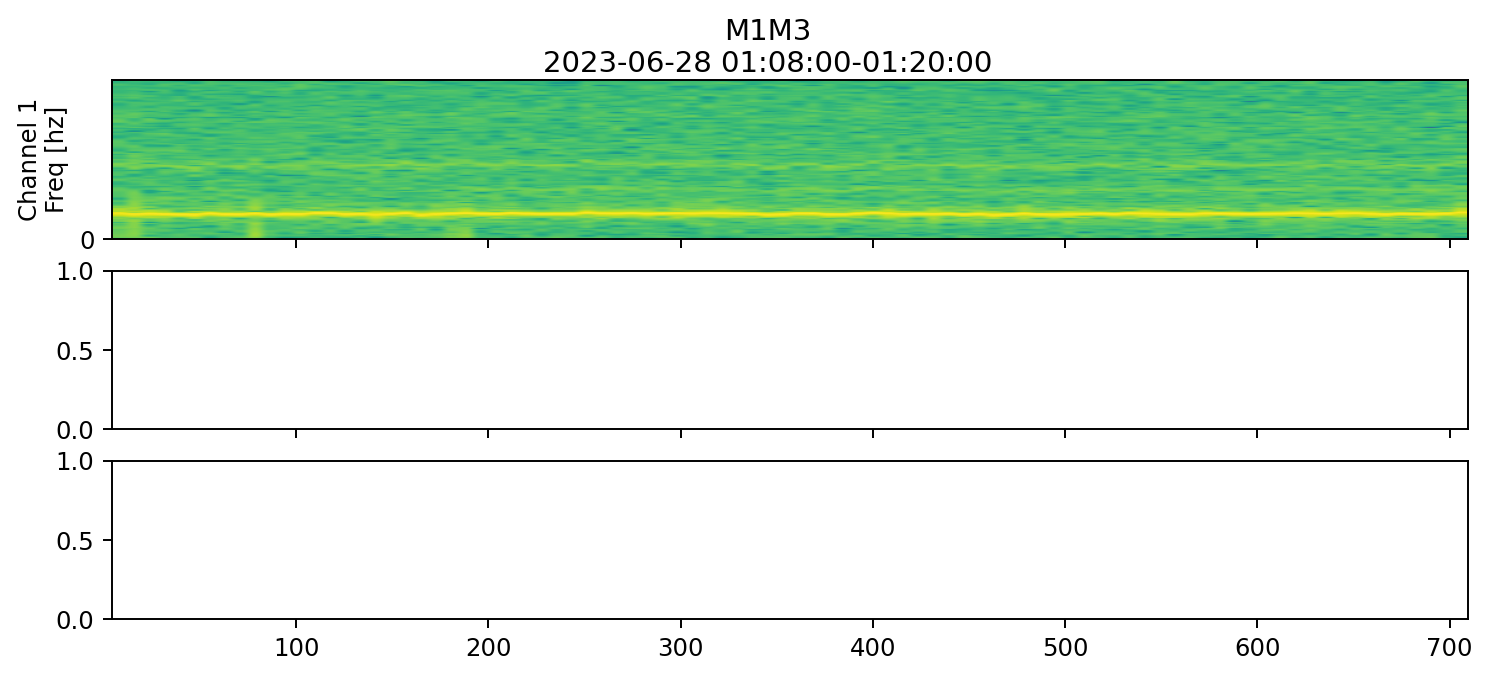

In [27]:
ydict={
    "el":"actualTorque",
    "ims":
}
fig,axs=plt.subplots(3, dpi=175, figsize=(10,4), sharex=True)
plt.suptitle(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.97)

for i, key in enumerate(["el","ims"])
times=Time(efd_dict["el"]["timestamp"], format="unix_tai", scale="utc")
fs=1/np.mean(np.diff(times.unix))
ax=axs[0]
ax.specgram(efd_dict["el"]["actualTorque"], Fs=fs, detrend="mean", vmin=-11)
ax.set(ylabel="Channel 1\nFreq [hz]", yticks=np.arange(0,16,25))

# ax=axs[1]
# ax.specgram(vms_m1m3_data["total_2"] - np.mean(vms_m1m3_data["total_2"]), Fs=fs, detrend="mean", vmin=-110)
# ax.set(ylabel="Channel 2\nFreq [hz]", yticks=np.arange(25,125,25))

# ax=axs[2]
# ax.specgram(vms_m1m3_data["total_3"] - np.mean(vms_m1m3_data["total_3"]), Fs=fs, detrend="mean", vmin=-110)
# ax.set(xlabel=f"time since {begin_time.iso[11:19]} [s]", ylabel="Channel 3\nFreq [hz]", yticks=np.arange(25,125,25))


# plt.subplots_adjust(hspace=0.1)
